In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [2]:
from src.eunms import Model_Type, Scheduler_Type
from src.utils.enums_utils import get_pipes
from src.config import RunConfig

from main import run as invert
from main import create_noise_list
from diffusers.utils import make_image_grid
import torch

# from ptp_utils import AttentionStore
# import ptp_utils
from attention_maps_utils_by_timesteps import (
    # from attention_maps_utils import (
    attn_maps,
    cross_attn_init,
    register_cross_attention_hook,
    set_layer_with_name_and_path,
    preprocess,
    visualize_and_save_attn_map,
)


from PIL import Image

/cortex/users/yairshp/miniconda3/envs/renoise_inversion/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/cortex/users/yairshp/miniconda3/envs/renoise_inversion/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/cortex/users/yairshp/miniconda3/envs/renoise_inversion/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/cortex/users/yairshp/miniconda3/envs/renoise_inversion/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarnin

In [3]:
device = "cuda"
model_type = Model_Type.SDXL_Turbo
# model_type = Model_Type.SDXL
scheduler_type = Scheduler_Type.EULER
# model_type = Model_Type.SD21
# scheduler_type = Scheduler_Type.DDIM
pipe_inversion, pipe_inference = get_pipes(model_type, scheduler_type, device=device)

Keyword arguments {'safety_checker': None} are not expected by StableDiffusionXLImg2ImgPipeline and will be ignored.
Loading pipeline components...:  29%|██▊       | 2/7 [00:00<00:01,  3.09it/s]/cortex/users/yairshp/miniconda3/envs/renoise_inversion/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]


In [4]:
inputs_images = [
    (
        Image.open("/home/lab/yairshp/projects/insert_object/benchmark/bed.jpeg")
        .convert("RGB")
        .resize((512, 512))
    ),
    Image.open("/home/lab/yairshp/projects/insert_object/benchmark/desk.jpeg")
    .convert("RGB")
    .resize((512, 512)),
    Image.open("/home/lab/yairshp/projects/insert_object/benchmark/cabinet.jpeg")
    .convert("RGB")
    .resize((512, 512)),
    Image.open("/home/lab/yairshp/projects/insert_object/benchmark/face.jpg")
    .convert("RGB")
    .resize((512, 512)),
    Image.open("example_images/lion.jpeg").convert("RGB").resize((512, 512)),
]
prompts = [
    "a bed",
    "a desk",
    "a cabinet",
    "a man",
]
edit_propmts = [
    "a bed and a pillow",
    "a desk and a plant",
    "a cabinet and a vase",
    "a man and a hat",
]

config = RunConfig(
    model_type=model_type,
    scheduler_type=scheduler_type,
    # guidance_scale=1.0,
    noise_regularization_lambda_kl=0.08,
    noise_regularization_lambda_ac=40,
    # inversion_max_step=1,
    # num_inversion_steps=50,
    # num_inference_steps=50,
    # num_renoise_steps=1,
    # perform_noise_correction=False,
)

In [5]:
inv_latents = []
noises = []
for i, (input_image, prompt) in enumerate(zip(inputs_images, prompts)):
    edit_img, inv_latent, noise, all_latents = invert(
        input_image,
        prompt,
        config,
        pipe_inversion=pipe_inversion,
        pipe_inference=pipe_inference,
        do_reconstruction=False,
    )
    inv_latents.append(inv_latent)
    noises.append(noise)

Inverting...


100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Inverting...


100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Inverting...


100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Inverting...


100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


In [6]:
cross_attn_init()
pipe_inference.unet = set_layer_with_name_and_path(pipe_inference.unet)
pipe_inference.unet = register_cross_attention_hook(pipe_inference.unet)

In [7]:
edit_images = []
for i, (inv_latent, noise, edit_prompt) in enumerate(
    zip(inv_latents, noises, edit_propmts)
):
    if not i == 0:
        continue
    generator = torch.Generator().manual_seed(config.seed)
    pipe_inference.scheduler.set_noise_list(noise)
    pipe_inference.cfg = config
    img = pipe_inference(
        prompt=edit_prompt,
        num_inference_steps=config.num_inference_steps,
        negative_prompt=prompt,
        image=inv_latent,
        strength=config.inversion_max_step,
        denoising_start=1.0 - config.inversion_max_step,
        guidance_scale=config.guidance_scale,
    ).images[0]
    edit_images.append(img)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 14.56it/s]


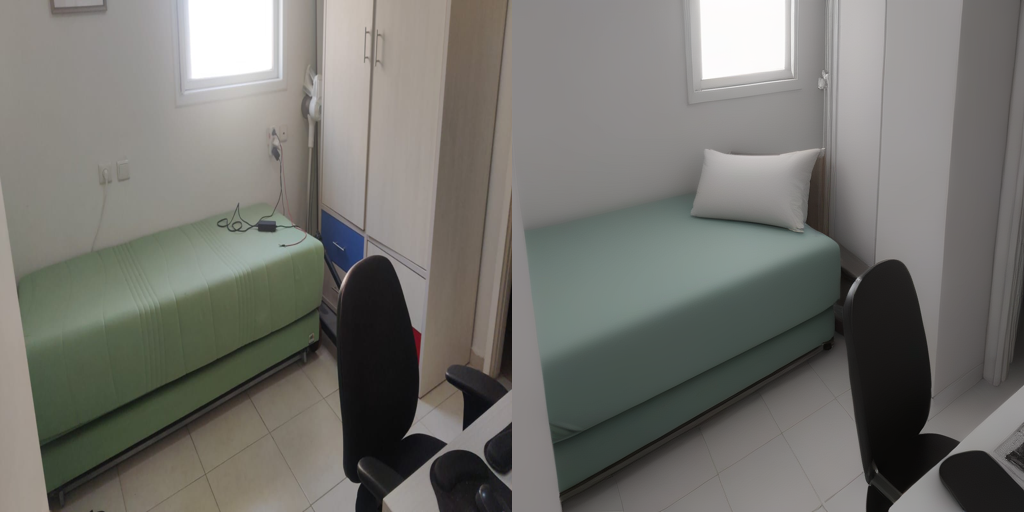

In [8]:
# for input_image, edit_img in zip(inputs_images, edit_images):
i = 0
make_image_grid([inputs_images[i], edit_images[i]], 1, 2)

In [11]:
# # attn_map = preprocess(max_height=512, max_width=512)
# visualize_and_save_attn_map(attn_map, pipe_inference.tokenizer, edit_propmts[3])
from attention_maps_utils_by_timesteps import get_attn_maps

attn_maps = get_attn_maps()

In [12]:
timestep = 3
attn_map = preprocess(attn_maps[timestep], 512, 512)
attn_map_img = visualize_and_save_attn_map(
    attn_map, pipe_inference.tokenizer, edit_propmts[0], 5
)

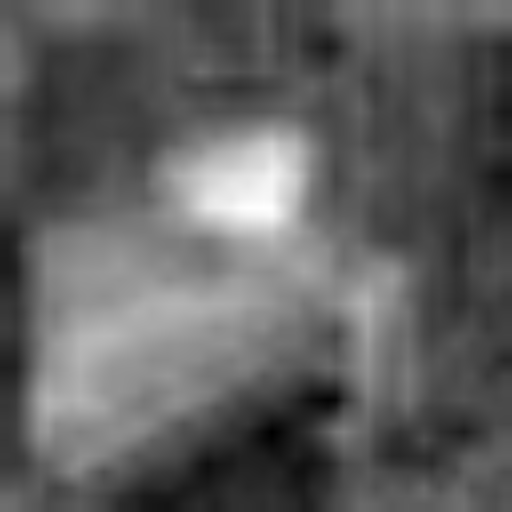

In [13]:
attn_map_img

In [14]:
import numpy as np

attn_map_arr = np.array(attn_map_img)

In [15]:
max_index = np.argmax(attn_map_arr)
max_x = max_index % attn_map_arr.shape[1]
max_y = max_index // attn_map_arr.shape[1]
print("Max Value Coordinates: x =", max_x, ", y =", max_y)

Max Value Coordinates: x = 263 , y = 207


In [20]:
import torch
from PIL import Image
from transformers import SamModel, SamProcessor

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

# img_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
# raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
input_points = [[[max_x, max_y]]]  # 2D location of a window in the image

inputs = processor(edit_images, input_points=input_points, return_tensors="pt").to(
    device
)
with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(),
    inputs["original_sizes"].cpu(),
    inputs["reshaped_input_sizes"].cpu(),
)
scores = outputs.iou_scores

/cortex/users/yairshp/miniconda3/envs/renoise_inversion/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [29]:
masks = masks[0].squeeze().numpy()

In [30]:
masks.shape

(3, 512, 512)

In [31]:
from PIL import Image

mask_images = []
for mask in masks:
    mask_image = Image.fromarray(mask.astype("uint8") * 255)
    mask_images.append(mask_image)

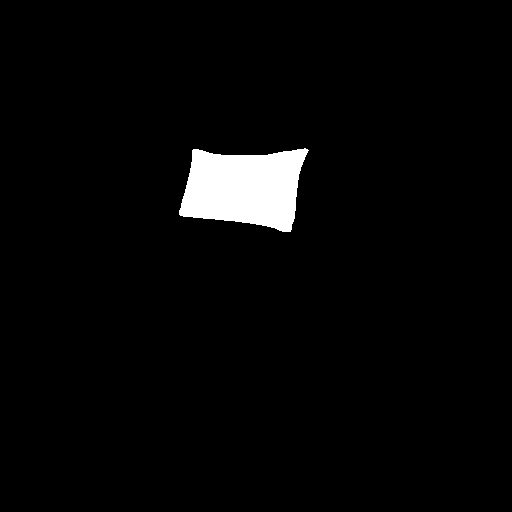

In [35]:
mask_images[0]

In [36]:
mask = mask_images[0]

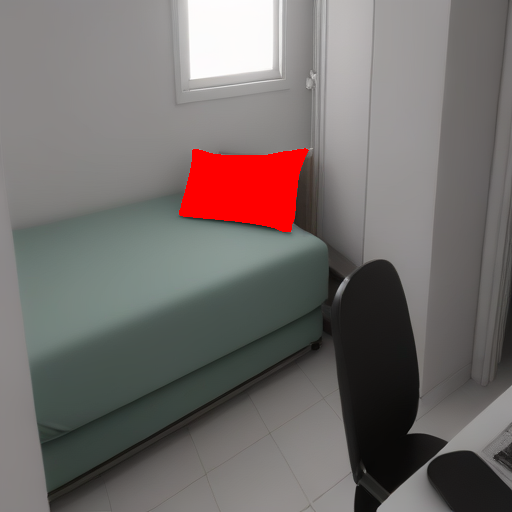

In [40]:
import numpy as np
from PIL import Image

# Convert the image and mask to numpy arrays
image_np = np.array(edit_images[0])
mask_np = np.array(mask_images[0])

# Create a copy of the image
masked_image_np = np.copy(image_np)

# Set the pixels inside the mask to red
masked_image_np[mask_np == 255] = [255, 0, 0]  # Set RGB values to [255, 0, 0] for red

# Create a PIL Image from the numpy array
masked_image = Image.fromarray(masked_image_np)

# Display the masked image
masked_image